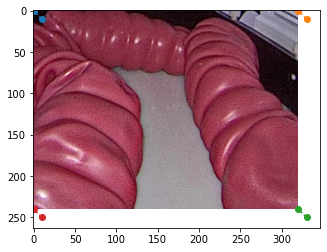

In [2]:
# load model
# load data, img seq? test / val



# current image
# blend immeadiate future and warped edges in image
# 
# or just warp and visualize edges with line connections


############################
#
#
#     o--o          o
#                    \
#                     o 
#     o
#      \
#       o          o-o
#
#
############################

import sys
sys.path.append("../..")

import torch
import kornia
import numpy as np
import matplotlib.pyplot as plt

from utils.processing import image_edges


img = np.load("/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames/vid_0/frame_0.npy")
img = kornia.image_to_tensor(img, keepdim=False)

pts0 = image_edges(img)
pts1 = pts0 + 10
pts = torch.cat([pts0, pts1], dim=0)
pts = pts.numpy()


# Nx4x2
# for N (connect N)
#     for 4
#         list? n0, n1, ...
#         x/y
# gif blend actual images
# N1 = pts[:,0,0] -> pts[:,0,1]
# N2 = pts[:,1,0] -> pts[:,1,1]
# N3 = pts[:,2,0] -> pts[:,2,1]
# N4 = pts[:,3,0] -> pts[:,3,1]


img = kornia.tensor_to_image(img, False)
plt.imshow(img)

plt.plot(pts[:,0,1], pts[:,0,0], linestyle="--", marker="o") 
plt.plot(pts[:,1,1], pts[:,1,0], linestyle="--", marker="o") 
plt.plot(pts[:,2,1], pts[:,2,0], linestyle="--", marker="o") 
plt.plot(pts[:,3,1], pts[:,3,0], linestyle="--", marker="o") 
plt.show()

/home/martin/.local/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/home/martin/Dev/homography_imitation_learning/notebooks/21_11_29_visualize_homography_imitation/../../utils/viz/figures.py:94: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(uv.shape) is not 3:
/home/martin/Dev/homography_imitation_learning/notebooks/21_11_29_visualize_homography_imitation/../../utils/viz/figures.py:96: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(uv_pred.shape) is not 3:
/home/martin/miniconda3/envs/torch19/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally

torch.Size([2, 4, 2]) torch.Size([2, 4, 2])


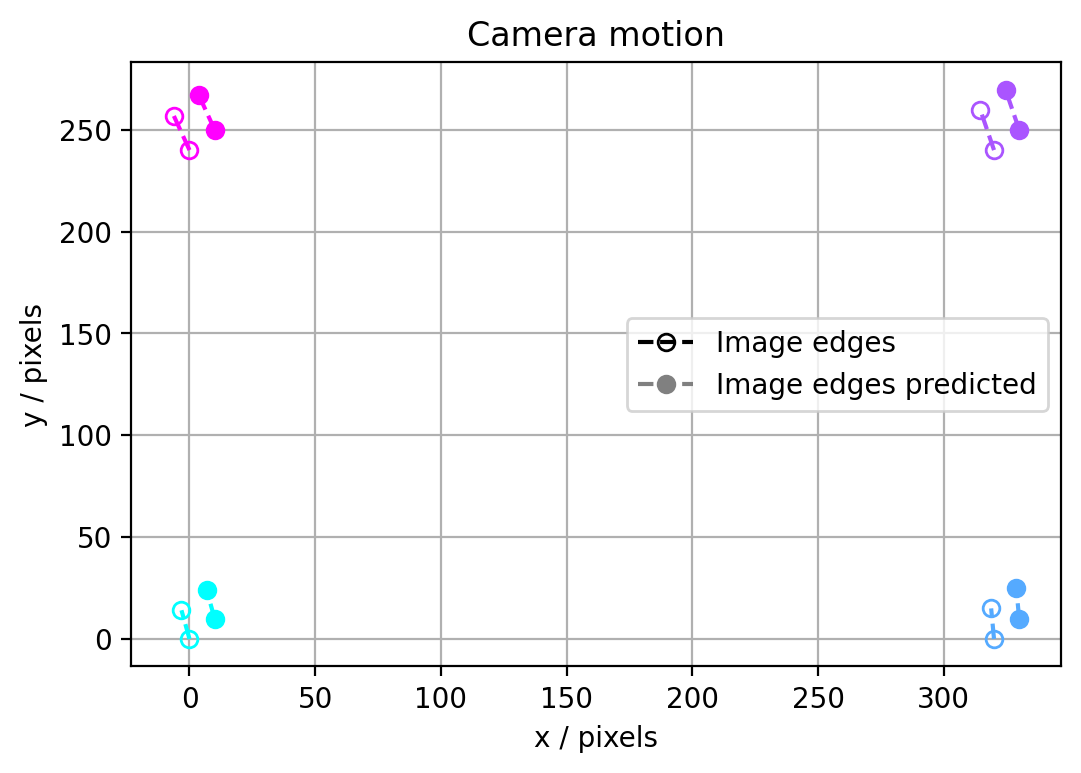

In [1]:
# estimate motion

# load model
from os.path import join
import sys
sys.path.append("../..")
import kornia
import numpy as np
import torch
import matplotlib.pyplot as plt

from lightning_modules import DeepImageHomographyEstimationModuleBackbone
from utils.io import load_yaml
from utils.viz import uv_trajectory_figure

prefix = "/home/martin/Tresors/homography_imitation_learning_logs/ae_cai/resnet/48/25/34/version_0"
config = load_yaml(join(prefix, "config.yml"))

model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(
    join(prefix, "checkpoints/epoch=99-step=47199.ckpt"), **config["model"]
)
model = model.eval()
model.freeze()

# load and convert data
n = 0
dn = 200
img = np.load("/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames/split_0/frame_{}.npy".format(n))
wrp = np.load("/media/martin/Samsung_T5/data/endoscopic_data/21_11_25_first_test_data_frames/split_0/frame_{}.npy".format(n + dn))

img, wrp = kornia.image_to_tensor(img, False).float()/255., kornia.image_to_tensor(wrp, False).float()/255.

# predict motion
duv = model(img, wrp)

# plot
from kornia.geometry import warp_perspective
from utils.processing import image_edges, four_point_homography_to_matrix
from utils.viz import yt_alpha_blend

uv = image_edges(img)
h = four_point_homography_to_matrix(uv, -duv)  # inverse
wrp_pred = warp_perspective(img, h, img.shape[-2:])

blend = yt_alpha_blend(wrp, wrp_pred)
blend = kornia.tensor_to_image(blend, False)


# "horizon"
pts = torch.cat([uv, uv-duv])
pts_pred = pts + 10


# plt.imshow(blend)
from matplotlib import cm
from matplotlib.lines import Line2D


print(pts.shape, pts_pred.shape)

fig = uv_trajectory_figure(pts.numpy(), pts_pred.numpy())
plt.show()